# QOSF Mentorship Programme
## Task 2

Implement a circuit that returns $| 01 \rangle$ and $|10 \rangle$ with equal probability.

Requirements :
- The circuit should consist only of CNOTs, RXs and RYs. 
- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
- You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
- Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

Bonus question:
How to make sure you produce state $|01 \rangle + |10 \rangle$ and not $|01 \rangle - |10 \rangle$?

I have decided to use Qiskit in my code as I'm quite comfortable with it.

In [1]:
# Importing necessary libraries 
# and predefining backends
from qiskit import execute, Aer, QuantumCircuit 
from qiskit.visualization import plot_histogram, plot_state_qsphere
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

q_simulator = Aer.get_backend('qasm_simulator')
st_simulator = Aer.get_backend('statevector_simulator')

## Trial circuit
Let us implement a quantum circuit with known parameters that yields an equal probability of $| 01 \rangle$ and $| 10 \rangle$ to get an idea of what gates the circuit must consist of.

In [2]:
# Define a quantum circuit consisting of 2 qubits
qc = QuantumCircuit(2)
qcr = QuantumCircuit(2)

# Hadamard gate on qubit 0
qc.ry(np.pi/2, 0)
qc.rx(np.pi, 0)
qcr.h(0)

# X gate on qubit 1
qc.rx(np.pi, 1)
qcr.x(1)

# CNOT gate with qubit 0, qubit 1 as the control and target qubits respectively
qc.cx(0,1)
qcr.cx(0,1)
qc.measure_all()
qcr.measure_all()

Reference circuit: 


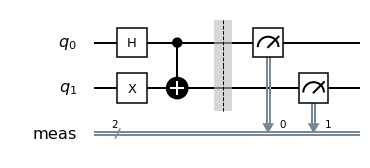

In [3]:
print("Reference circuit: ")
qcr.draw()

Parameterized circuit: 


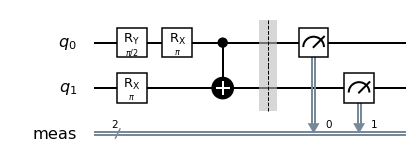

In [4]:
print("Parameterized circuit: ")
qc.draw()

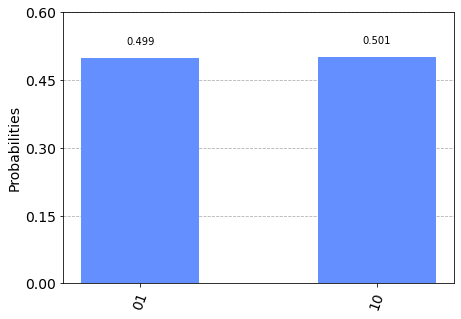

In [5]:
counts = execute(qc, q_simulator, shots=1000).result().get_counts()
plot_histogram(counts)

As can be seen from the histogram plot, we get the desired output. Our goal now is to parameterize the circuit by introducing unknown parameters to the RX and RY gates.

When trying to find the optimal solution to the parameterized problem, the CNOT gate does not play a role since it does not depend on parameters. Hence, the goal is to find the optimum solution to the state of the qubits just before applying the CNOT gate.

Let us see the effect of the gates used in the trial circuit to find the state of the system at the end of the circuit.

All qubits are initialized to the state $| 0 \rangle$ thus initializing the system at $| 00 \rangle$. Applying a Hadamard gate to the 1st qubit yields, 

$$ |00 \rangle \longrightarrow |0 \rangle \otimes \frac{1}{\sqrt{2}} (|0 \rangle + |1 \rangle)$$

It is a good point to note here that Qiskit orders its qubits in a different way compared to the textbook convention. In Qiskit, if $q_0$ and $q_1$ are the 1st and 2nd qubits respectively, then the composite system is written as

$$ |q_1 q_0 \rangle = |q_1 \rangle \otimes |q_0 \rangle$$

Now applying an X gate onto the second qubit,

$$ |0 \rangle \otimes \frac{1}{\sqrt{2}}(|0 \rangle + |1 \rangle) \longrightarrow |1 \rangle \otimes \frac{1}{\sqrt{2}} (|0 \rangle + |1 \rangle)$$

Finally applying a CNOT gate (with the first qubit as the control and the second qubit as the target), we get

$$ |1 \rangle \otimes \frac{1}{\sqrt{2}} (|0 \rangle + |1 \rangle) \longrightarrow \frac{1}{\sqrt{2}} (|10 \rangle + |01 \rangle) = |\psi \rangle$$

This final state $|\psi \rangle$ upon measurement, will yield $|10 \rangle$ with a probability of 0.5 and $|01 \rangle$ with a probability of 0.5.

However, since we are not concerned with unparameterized operations, we only have to worry about the state of the system just before the application of the CNOT gate. That state would be,

$$ | \phi \rangle = |1 \rangle \otimes \frac{1}{\sqrt{2}}(|0 \rangle + |1 \rangle)$$

This state is clearly unentangled, meaning that the corresponding qubits are independent and that we can treat the problem as 2 separate optimization problems.

In [6]:
## Initializing parameters with random values

# q0_thetas holds parameters for the first qubit and q1_thetas holds parameters for the second qubit
q0_thetas = [ random.uniform(0.001, 2 * np.pi) for i in range(2)]
q1_thetas = [ random.uniform(0.001, 2 * np.pi) for i in range(2)]

Let us define a function that returns a parameterized quantum circuit

In [7]:
def circuit(params0, params1):
    circuit = QuantumCircuit(2)
    circuit.ry(params0[0], 0)
    circuit.rx(params0[1], 0)
    circuit.ry(params1[0], 1)
    circuit.rx(params1[1], 1)
    
    return circuit

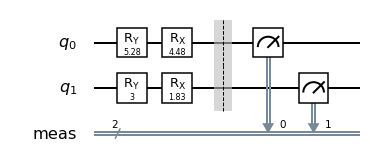

In [8]:
circ = circuit(q0_thetas, q1_thetas)
circ.measure_all()
circ.draw()

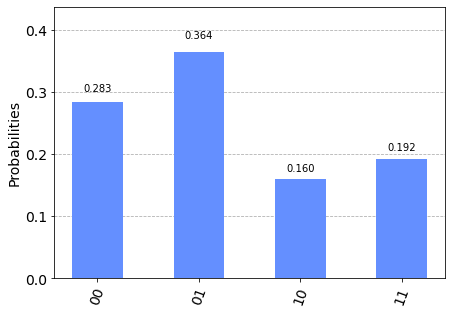

In [9]:
cnt = execute(circ, q_simulator).result().get_counts()
plot_histogram(cnt)

Our goal here is to optimize the parameters such that measuring $q_1$ yields that state $|1 \rangle$ with probability 1 and measuring $q_0$ yields the states $|0 \rangle$ and $|1 \rangle$ with probabilities 0.5 each.

## Cost function

Since the 2 qubits can be treated independently, let us define 2 cost functions to optimize their respective parameters.

Let $J_0$ and $J_1$ be the cost functions of $q_0$ and $q_1$ respectively. Since we're dealing with probability, let us implement it into these cost functions. 

### Qubit 0
$$ J_0 = \frac{1}{4} ((P_0 - 0.5)^2 + (P_1 - 0.5)^2)$$

### Qubit 1
$$ J_1 = \frac{1}{4} (P_0^2 + (P_1 - 1)^2)$$

where $P_0$ and $P_1$ are the probabilities of measuring $|0 \rangle$ and $|1 \rangle$ respectively.

We wish to minimize the above 2 cost functions using batch gradient descent as our optimization method.

Now let us analytically deduce the operations the gates perform on our initial qubit state $| 00 \rangle$.

The $R_X$ gate corresponds to,

$$
R_X (\theta) = 
\begin{pmatrix}
\cos \frac{\theta}{2} & -i \sin \frac{\theta}{2} \\
-i \sin \frac{\theta}{2} & \cos \frac{\theta}{2} \\
\end{pmatrix}
$$

The $R_Y$ gate corresponds to,

$$
R_Y (\theta) = 
\begin{pmatrix}
\cos \frac{\theta}{2} & - \sin \frac{\theta}{2} \\ 
\sin \frac{\theta}{2} & \cos \frac{\theta}{2} \\  
\end{pmatrix}
$$


The operation of these matrices on initial state $|0 \rangle$ yields,

$$
|0 \rangle \xrightarrow[]{R_Y (\theta_0)}
\begin{pmatrix}
\cos \frac{\theta_0}{2} \\ 
\sin \frac{\theta_0}{2} \\  
\end{pmatrix}
\xrightarrow[]{R_X (\theta_1)}
\begin{pmatrix}
\cos \frac{\theta_0}{2} \cos \frac{\theta_1}{2} - i \sin \frac{\theta_0}{2} \sin \frac{\theta_1} {2} \\
-i \sin \frac{\theta_1}{2} \cos \frac{\theta_0}{2} + \cos \frac{\theta_1}{2} \sin \frac{\theta_0}{2} \\
\end{pmatrix}
= | \psi \rangle
$$

This is the state obtained on both the qubits in the unparameterized circuit. From this state $| \psi \rangle$, the probabilities of obtaining $|0 \rangle$ and $|1 \rangle$ can be obtained by computing the corresponding modulus of inner products,

$$
| \langle 0 | \psi \rangle |^2 = \cos^2 \frac{\theta_0}{2} \cos^2 \frac{\theta_1}{2} + \sin^2 \frac{\theta_0}{2} \sin^2 \frac{\theta_1}{2} = P_0
$$

$$
| \langle 1 | \psi \rangle |^2 = \cos^2 \frac{\theta_1}{2} \sin^2 \frac{\theta_0}{2} + \sin^2 \frac{\theta_1}{2} \cos^2 \frac{\theta_0}{2} = P_1
$$

## Batch Gradient Descent

Let us now get into the meat of the optimization problem. Since we are implementing batch gradient descent, the parameters have to be updated as

$$
\theta_{i+1} := \theta_i - \alpha \frac{\partial }{\partial \theta_i} J (\theta_0, \theta_1)
$$

where $\theta_{i+1}$ is the updated parameter and $\alpha$ is the learning rate.



In general, batch gradient descent is not useful when minimizing functions that consist of various local minima, since the optimizer will get stuck once it ends on a local minima. However, lucky for us, the cost function that we are minimizing has a single minima (global minima) and is the point that we intend the optimizer to reach. 

Let us verify this through a plot of cost function as a function of $\theta$.

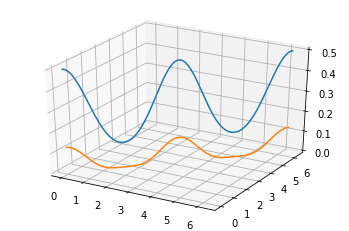

In [10]:
from mpl_toolkits import mplot3d

def z_function(x, y):
    p0 = (np.cos(x/2)**2) * (np.cos(y/2)**2) + (np.sin(x/2)**2)*(np.sin(y/2)**2)
    p1 = (np.cos(y/2)**2) * (np.sin(x/2)**2) + (np.sin(y/2)**2)*(np.cos(x/2)**2)

    z1 = 0.25 * ((p0)**2 + (p1 - 1)**2)
    z2 = 0.25 * ((p0 - 0.5)**2 + (p1 - 0.5)**2)
    return z1, z2

x = np.linspace(0, 2*np.pi, 1000)
y = np.linspace(0, 2*np.pi, 1000)
z1, z2 = z_function(x, y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(x, y, z1)
ax.plot3D(x, y, z2)

Computing the respective partial derivatives of both cost funtions $J_0$ and $J_1$,

$$
\frac{\partial J_0}{\partial \theta_0} = \frac{1}{2}\left((P_0 - 0.5) \frac{\partial P_0}{\partial \theta_0} + (P_1 - 0.5) \frac{\partial P_1}{\partial \theta_0}\right)
$$

$$
\frac{\partial J_0}{\partial \theta_1} = \frac{1}{2}\left((P_0 - 0.5) \frac{\partial P_0}{\partial \theta_1} + (P_1 - 0.5) \frac{\partial P_1}{\partial \theta_1}\right)
$$

$$
\frac{\partial J_1}{\partial \theta_0} = \frac{1}{2}\left(P_0 \frac{\partial P_0}{\partial \theta_0} + (P_1 - 1) \frac{\partial P_1}{\partial \theta_0}\right)
$$

$$
\frac{\partial J_1}{\partial \theta_1} = \frac{1}{2}\left(P_0 \frac{\partial P_0}{\partial \theta_1} + (P_1 - 1) \frac{\partial P_1}{\partial \theta_1}\right)
$$

Now, computing the partial derivatives of $P_0$ and $P_1$ with respect to the parameters,

$$
\frac{\partial P_0}{\partial \theta_0} = - \cos \frac{\theta_0}{2} \sin \frac{\theta_0}{2} \cos^2 \frac{\theta_1}{2} + \sin \frac{\theta_0}{2} \cos \frac{\theta_0}{2} \sin^2 \frac{\theta_1}{2} = -\frac{1}{2} \sin \theta_0 \cos \theta_1
$$

$$
\frac{\partial P_0}{\partial \theta_1} = - \cos \frac{\theta_1}{2} \sin \frac{\theta_1}{2} \cos^2 \frac{\theta_0}{2} + \sin \frac{\theta_1}{2} \cos \frac{\theta_1}{2} \sin^2 \frac{\theta_0}{2} = -\frac{1}{2} \sin \theta_1 \cos \theta_0
$$

$$
\frac{\partial P_1}{\partial \theta_0} = \sin \frac{\theta_0}{2} \cos \frac{\theta_0}{2} \cos^2 \frac{\theta_1}{2} - \sin^2 \frac{\theta_1}{2} \cos \frac{\theta_0}{2} \sin \frac{\theta_0}{2} = \frac{1}{2} \sin \theta_0 \cos \theta_1
$$

$$
\frac{\partial P_1}{\partial \theta_1} = -\cos \frac{\theta_1}{2} \sin \frac{\theta_1}{2} \sin^2 \frac{\theta_0}{2} + \sin \frac{\theta_1}{2} \cos \frac{\theta_1}{2} \cos^2 \frac{\theta_0}{2} = \frac{1}{2} \sin \theta_1 \cos \theta_0
$$

## Partial derivatives of $J_i$ in terms of parameters $\theta_0$, $\theta_1$
Substituting the above relations into the equations for the partial derivatives of $J_i$, we get

$$
\frac{\partial J_0}{\partial \theta_0} = \frac{1}{4} \sin \theta_0 \cos \theta_1 (P_1 - P_0)
$$

$$
\frac{\partial J_0}{\partial \theta_1} = \frac{1}{4} \sin \theta_1 \cos \theta_0 (P_1 - P_0)
$$

$$
\frac{\partial J_1}{\partial \theta_0} = \frac{1}{4} \sin \theta_0 \cos \theta_1 (P_1 - P_0 -1)
$$

$$
\frac{\partial J_1}{\partial \theta_1} = \frac{1}{4} \sin \theta_1 \cos \theta_0 (P_1 - P_0 -1)
$$

Let us implement the above formulation in python.

In [11]:
## params = [theta0, theta1]

# Probability of measuring state |0>
def prob0(params):
    p0 = (np.cos(params[0]/2)**2)*(np.cos(params[1]/2)**2) + (np.sin(params[0]/2)**2)*(np.sin(params[1]/2)**2)
    return p0

# Probability of measuring state |1>
def prob1(params):
    p1 = (np.sin(params[0]/2)**2)*(np.cos(params[1]/2)**2) + (np.cos(params[0]/2)**2)*(np.sin(params[1]/2)**2)
    return p1

In [12]:
# Function that returns the cost function for given qubit (0 or 1)
def cost(params, qubit):
    if qubit==0:
        j0 = 0.25 * ((prob0(params) - 0.5)**2 + (prob1(params) - 0.5)**2)
        return j0
    
    elif qubit==1:
        j1 = 0.25 * (prob0(params)**2 + (prob1(params) - 1)**2)
        return j1
    
    else:
        print("Qubit index out of range!!!")
        exit()

In [13]:
## Computes gradient for qubit 0
# q0_thetas = [theta0, theta1]; i = index (0 for theta0, 1 for theta1) denotes the theta w.r.t the partial derivative
def gradient_q0(q0_thetas, i):
    p0 = prob0(q0_thetas)
    p1 = prob1(q0_thetas)
    
    if i==0:
        grad = 0.25 * np.sin(q0_thetas[0]) * np.cos(q0_thetas[1]) * (p1 - p0)
        return grad
    
    elif i==1:
        grad = 0.25 * np.sin(q0_thetas[1]) * np.cos(q0_thetas[0]) * (p1 - p0)
        return grad
    
    else:
        print("Incorrect index!!!")
        exit()
    
## Computes gradient for qubit 1
# q1_thetas = [theta0, theta1]; i = index (0 for theta0, 1 for theta1) denotes the theta w.r.t the partial derivative
def gradient_q1(q1_thetas, i):
    p0 = prob0(q1_thetas)
    p1 = prob1(q1_thetas)
    
    if i==0:
        grad = 0.25 * np.sin(q1_thetas[0]) * np.cos(q1_thetas[1]) * (p1 - p0 - 1)
        return grad
    
    elif i==1:
        grad = 0.25 * np.sin(q1_thetas[1]) * np.cos(q1_thetas[0]) * (p1 - p0 - 1)
        return grad
    
    else:
        print("Incorrect index!!!")
        exit()

In [14]:
## Gradient descent optimizer function
# params = [theta0, theta1], qubit is the index of the qubit parameters being optimized
def optimizer(params, learning_rate, qubit):
    if qubit==0:
        temp0 = params[0] - (learning_rate * gradient_q0(params, 0))
        temp1 = params[1] - (learning_rate * gradient_q0(params, 1))
        params[0] = temp0
        params[1] = temp1
       
    elif qubit==1:
        temp0 = params[0] - (learning_rate * gradient_q1(params, 0))
        temp1 = params[1] - (learning_rate * gradient_q1(params, 1))
        params[0] = temp0
        params[1] = temp1
        
    else:
        print("Out of range of qubits!!!")
        exit()

In [15]:
## Initializing important variables
# Number of iterations
iterations = 1000

# Learning rate
learning_rate = 0.04

In [16]:
# Make copies of the initial parameter so as to compare the values of the parameters before and after optimization
params0 = q0_thetas.copy()
params1 = q1_thetas.copy()

In [17]:
# Qubit 0 optimization
for i in range(iterations):
    optimizer(params0, learning_rate, 0)
    
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i+1, cost(params0, 0)))
    
print("Optimized parameters", params0)
    
# Qubit 1 optimization
for j in range(iterations):
    optimizer(params1, learning_rate, 1)
    
    if (j + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(j+1, cost(params1, 1)))
    
print("Optimized parameters", params1)

Cost after step     5:  0.0018598
Cost after step    10:  0.0018025
Cost after step    15:  0.0017473
Cost after step    20:  0.0016941
Cost after step    25:  0.0016427
Cost after step    30:  0.0015931
Cost after step    35:  0.0015452
Cost after step    40:  0.0014989
Cost after step    45:  0.0014542
Cost after step    50:  0.0014110
Cost after step    55:  0.0013693
Cost after step    60:  0.0013290
Cost after step    65:  0.0012900
Cost after step    70:  0.0012522
Cost after step    75:  0.0012158
Cost after step    80:  0.0011805
Cost after step    85:  0.0011463
Cost after step    90:  0.0011133
Cost after step    95:  0.0010813
Cost after step   100:  0.0010503
Cost after step   105:  0.0010204
Cost after step   110:  0.0009913
Cost after step   115:  0.0009632
Cost after step   120:  0.0009360
Cost after step   125:  0.0009096
Cost after step   130:  0.0008840
Cost after step   135:  0.0008592
Cost after step   140:  0.0008352
Cost after step   145:  0.0008119
Cost after ste

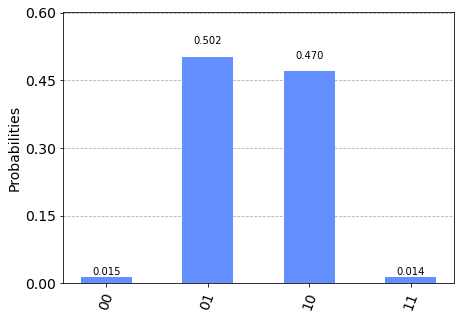

In [18]:
qc = circuit(params0, params1)
qc.cx(0,1)
qc.measure_all()
counts = execute(qc, q_simulator).result().get_counts()
plot_histogram(counts)

## Variations in number of measurements

### i) 1 measurement

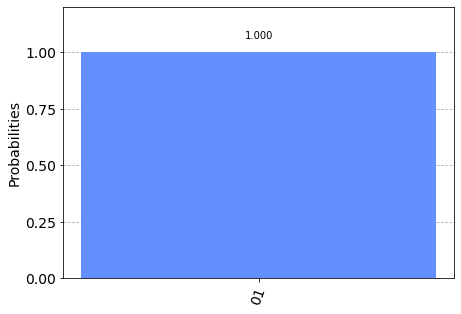

In [19]:
shots = 1
counts = execute(qc, q_simulator, shots=shots).result().get_counts()
plot_histogram(counts)

### ii) 10 measurements

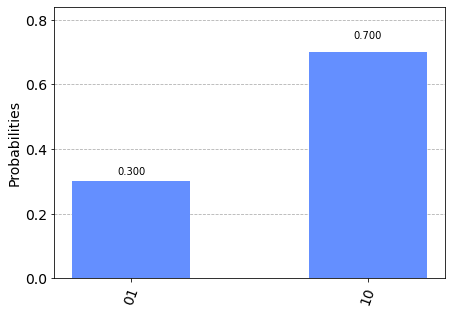

In [20]:
shots = 10
counts = execute(qc, q_simulator, shots=shots).result().get_counts()
plot_histogram(counts)

### iii) 100 measurements

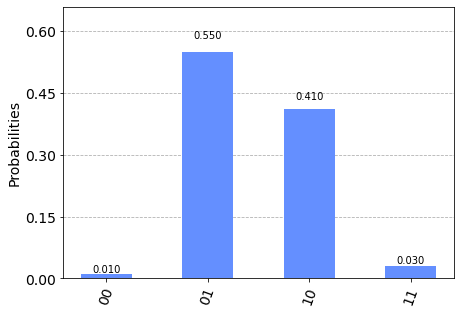

In [21]:
shots = 100
counts = execute(qc, q_simulator, shots=shots).result().get_counts()
plot_histogram(counts)

### iv) 1000 measurements

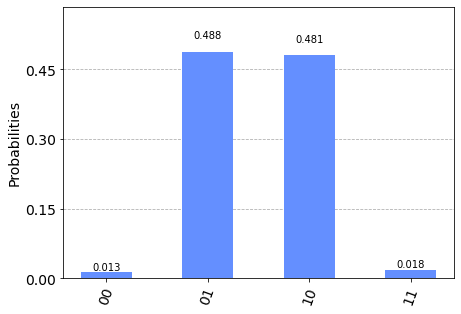

In [22]:
shots = 1000
counts = execute(qc, q_simulator, shots=shots).result().get_counts()
plot_histogram(counts)

# Implementation in PennyLane

In [23]:
# Necessary imports
import pennylane as qml
from pennylane import numpy as np

## Construction of the circuit
PennyLane provides us with built-in optimizers that will take care of the mathematical rigor that we implemented above in Qiskit. For this reason, we directly construct the parameterized circuit and measure the probability of measuring the states $|00 \rangle$, $|01 \rangle$, $|10 \rangle$ and $|11 \rangle$.

In [120]:
# Defining the device (backend) to use
dev = qml.device("default.qubit", wires=2, shots=1000, analytic=False)

# Define a parameterized circuit
# params = [q0_theta0, q0_theta1, q1_theta0, q1_theta1]
@qml.qnode(dev)
def circuit(params):
    qml.RY(params[0], wires=0)
    qml.RX(params[1], wires=0)
    qml.RY(params[2], wires=1)
    qml.RX(params[3], wires=1)
    qml.CNOT(wires=[0,1])
    
    # return the probabilies of the states as a list
    return qml.probs(wires=[0,1])


After our initial qubit state $|00 \rangle$ undergoes operations under the parameterized, we arrive at a state say $| \psi \rangle$.

In [121]:
# Define a function that returns the probability of measuring a state of this composite system
# state = 0,1,2 or 3 where 0 = |00>, 1 = |01>, 2 = |10>, 3 = |11>
def probability(circuit, params, state):
    return circuit(params)[state]


## Cost function
Since we are using the entire circuit to optimize (unlike the case with Qiskit where we optimized upto the CNOT gate and treated both the qubits as 2 separate optimization problems), we will be optimizing the parameters of both the qubits at once. For this we'll implement a very straightforward cost function as a function of probabilities as implemented in our implementation in Qiskit.

A simple cost function would be

$$
J = (P_{00}^2 + (P_{01} - 0.5)^2 + (P_{10} - 0.5)^2 + P_{11}^2)
$$

Or as implemented in our code, it would be

$$
J = (P_0^2 + (P_1 - 0.5)^2 + (P_2 - 0.5)^2 + P_3^2)
$$

where $P_0 = | \langle 00 | \psi \rangle |^2$, $P_1 = | \langle 01 | \psi \rangle |^2$, $P_2 = | \langle 10 | \psi \rangle |^2$ and $P_3 = | \langle 11 | \psi \rangle |^2$.

Let us define this cost function in our code.

In [122]:
# Cost function with params = [q0_theta0, q0_theta1, q1_theta0, q1_theta1]
def cost(params):
    return (probability(circuit, params, 0)**2 + (probability(circuit, params, 1) - 0.5)**2 + (probability(circuit, params, 2) - 0.5)**2 + probability(circuit, params, 3)**2)

## Optimization using Gradient Descent

In [134]:
# Initial parameters (assign random values)
init_params = [random.uniform(0.001, 2*np.pi) for i in range(4)]

# Optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.04)

In [135]:
# Number of iterations
steps = 1000

# Assign initial parameters to a variable 'params' to be optimized
params = init_params

In [136]:
# Optimization over every loop
for i in range(steps):
    params = opt.step(cost, params)
    
    if (i+1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i+1, cost(params)))

Cost after step     5:  0.5005330
Cost after step    10:  0.4312660
Cost after step    15:  0.3723660
Cost after step    20:  0.3724090
Cost after step    25:  0.3605340
Cost after step    30:  0.3011700
Cost after step    35:  0.2719470
Cost after step    40:  0.2862340
Cost after step    45:  0.2322260
Cost after step    50:  0.2451710
Cost after step    55:  0.2489450
Cost after step    60:  0.1984920
Cost after step    65:  0.1647080
Cost after step    70:  0.1623820
Cost after step    75:  0.1333770
Cost after step    80:  0.1250630
Cost after step    85:  0.1104770
Cost after step    90:  0.1116460
Cost after step    95:  0.0957580
Cost after step   100:  0.0898250
Cost after step   105:  0.0752070
Cost after step   110:  0.0879850
Cost after step   115:  0.0707020
Cost after step   120:  0.0596820
Cost after step   125:  0.0473170
Cost after step   130:  0.0666690
Cost after step   135:  0.0393670
Cost after step   140:  0.0404910
Cost after step   145:  0.0442460
Cost after ste

### Variation in number of measurements

Change the number of `dev.shots` to vary the number of measurements

In [149]:
# Number of measurements
dev.shots = 100

In [150]:
# Print the probabilities of states after optimization
print("Probability of measuring states:\n")
print("|00> =", circuit(params)[0])
print("|01> =", circuit(params)[1])
print("|10> =", circuit(params)[2])
print("|11> =", circuit(params)[3])

Probability of measuring states:

|00> = 0.03
|01> = 0.46
|10> = 0.51
|11> = 0.0


## Bonus question: How to make sure that you produce the state $|01 \rangle + |10 \rangle$ and not $|01 \rangle - |10 \rangle$

Let us find the state of the system before making the measurement. For this we shall use the 'statevector_simulator' in Qiskit which allows us to know the state of the system without destroying it.

## Questions to ponder about


# To do
- Implement partial derivatives not by hand but through external libraries like Sympy.
- Implementing various other optimization techniques such as the Adam optimizer and gradient descent with momentum.
- ~Implement the same problem using PennyLane, which provides pre-build functions for optimization~ Used basic gradient descent in PennyLane.